In [1]:
from torchvision import datasets, transforms

# define transformations for the images
# rotate the image by 90 degree then flip horizontally
# normalize data to [-1, 1]
transform = transforms.Compose([
    transforms.Lambda(lambda img: transforms.functional.rotate(img, -90)),
    transforms.Lambda(lambda img: transforms.functional.hflip(img)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# get training and test dataset
train = datasets.EMNIST(root='./data', 
                        split='balanced', 
                        train=True,
                        download=True,
                        transform=transform
                        )

test = datasets.EMNIST(root='./data', 
                        split='balanced', 
                        train=False,
                        download=True,
                        transform=transform
                        )

print('number of training data and test data: '+ str(len(train)) + ', ' + str(len(test)))
print('classes in training data: ')
print(train.classes)
print(f"length of classes: {len(train.classes)}")

number of training data and test data: 112800, 18800
classes in training data: 
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
length of classes: 47


In [2]:
from torch.utils.data import DataLoader
# load dataset
train = DataLoader(train, batch_size=64, shuffle=True)
test = DataLoader(test, batch_size=64, shuffle=False)

In [3]:
print(f"length of training dataset after loading: {len(train)}")
print(f"length of test dataset after loading: {len(test)}")

length of training dataset after loading: 1763
length of test dataset after loading: 294


In [4]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

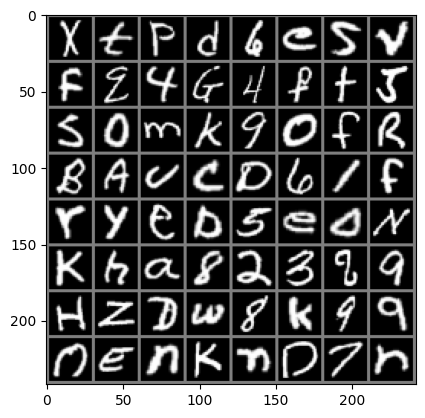

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# show image
def imgShow(img):
    # unnormalize
    img = img /2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# get some random training images (every run is diff)
dataiter = iter(train)
images, labels = next(dataiter)

# show images
imgShow(torchvision.utils.make_grid(images))

In [ ]:
# build CNN model
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self, num_classes=47): # 47 classes for balance split
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3,1)
        self.pool = nn.MaxPool2d(2, 2)

        # determine flatten dimention
        self.flatten_dim = self._get_flatten_dim()
        # get full connect layer latter
        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    # calculate flatten features
    def _get_flatten_dim(self):
        with torch.no_grad():
            # dummy image
            x = torch.zeros(1, 1, 28, 28)
            # conv1 -> relu -> conv2 -> relu
            x= self.pool(F.relu(self.conv2(F.relu(self.conv1(x)))))
            # get num of features
            return x.numel()
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv2(self.conv1(x))))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))

        return self.fc2(x)

In [7]:
# check model
model = CNN()
dummy = torch.randn(8, 1, 28,28)
out = model(dummy)
print(out.shape)

torch.Size([8, 47])


In [8]:
# define loss function and optimizer
import torch.optim as optim

# since no gpu, doesn't set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [9]:
# set 10 complet learning pass to improve performance
epochs = 10
for i in range(epochs):
    # set model to training mode
    model.train()
    totLoss= 0

    for X, y in train:
        # reset the gradient
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        totLoss += loss.item()
    
    print(f"Epoch {i+1}/{epochs}, Avg Loss: {totLoss/len(train):.4f}")
        

Epoch 1/10, Avg Loss: 0.7534
Epoch 2/10, Avg Loss: 0.4241
Epoch 3/10, Avg Loss: 0.3622
Epoch 4/10, Avg Loss: 0.3231
Epoch 5/10, Avg Loss: 0.2906
Epoch 6/10, Avg Loss: 0.2641
Epoch 7/10, Avg Loss: 0.2390
Epoch 8/10, Avg Loss: 0.2163
Epoch 9/10, Avg Loss: 0.1980
Epoch 10/10, Avg Loss: 0.1816


In [10]:
# evaluate the model
# change model to evaluating mode
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for X, y in test:
        # shape: [batch_size, num_classes]
        output = model(X)

        # pick index of largest value in each row
        pred = output.argmax(dim=1)
        # check true and pred
        # sum all correct then conver tensor to num
        correct += pred.eq(y).sum().item()
        total += y.size(0)

print(f"Accuracy: {100. * correct / total:.2f}%")

Accuracy: 85.71%


In [11]:
# save model
torch.save(model.state_dict, "emnist_cnn.pth")
print('saved the model')

saved the model
